## ANN approach for ARM


In [1]:
"""
@author: Dr. H K Patel, Pankaj, Aditya
"""
import time
start = time.time()
from sklearn.decomposition import NMF
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
cols = ['1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','20','21','22',
        '23','24','25','26','27','28','29','30','31','32']

df = pd.read_csv("groceries.csv", sep = ",", 
                 names = cols, engine = "python")
data = np.array(df)
df.head(5)

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,citrus fruit,semi-finished bread,margarine,ready soups,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,tropical fruit,yogurt,coffee,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,whole milk,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,pip fruit,yogurt,cream cheese,meat spreads,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,other vegetables,whole milk,condensed milk,long life bakery product,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [3]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
count,9835,7676,6033,4734,3729,2874,2229,1684,1246,896,...,14,8,7,7,6,5,4,1,1,1
unique,158,151,155,153,150,137,138,140,128,120,...,13,7,6,7,5,4,3,1,1,1
top,sausage,whole milk,whole milk,whole milk,rolls/buns,soda,soda,shopping bags,soda,shopping bags,...,waffles,bottled beer,chocolate,female sanitary products,hygiene articles,napkins,house keeping products,skin care,hygiene articles,candles
freq,825,654,506,315,176,150,120,76,61,49,...,2,2,2,1,2,2,2,1,1,1


In [4]:
df.shape

(9835, 32)

In [5]:
def get_unique_items(data):
    ncol = data.shape[1]
    items = set()
    for c in range(ncol):
        items = items.union(data[:,c])
    items = np.array(list(items))
    items = items[items != np.array(None)]

    return np.unique(items)

In [6]:
def get_onehot_items(data,unique_items):
    onehot_items = np.zeros((len(data),len(unique_items)),dtype = np.int)
    for i, r in enumerate(data):
        for j, c in enumerate(unique_items):
            onehot_items[i,j] = int(c in r)
            
    return onehot_items


In [7]:
def get_items_from_ohe(ohe,unique_items):
    return unique_items[np.flatnonzero(ohe)]

In [8]:
unique_items = get_unique_items(data)
onehot_items = np.array(get_onehot_items(data, unique_items))


n = 15
item_counts = (onehot_items != 0).sum(0)
items_max_args = item_counts.argsort()[-n:][::-1]
ic = pd.DataFrame({"Items":unique_items[items_max_args], "Frequency":item_counts[items_max_args]})


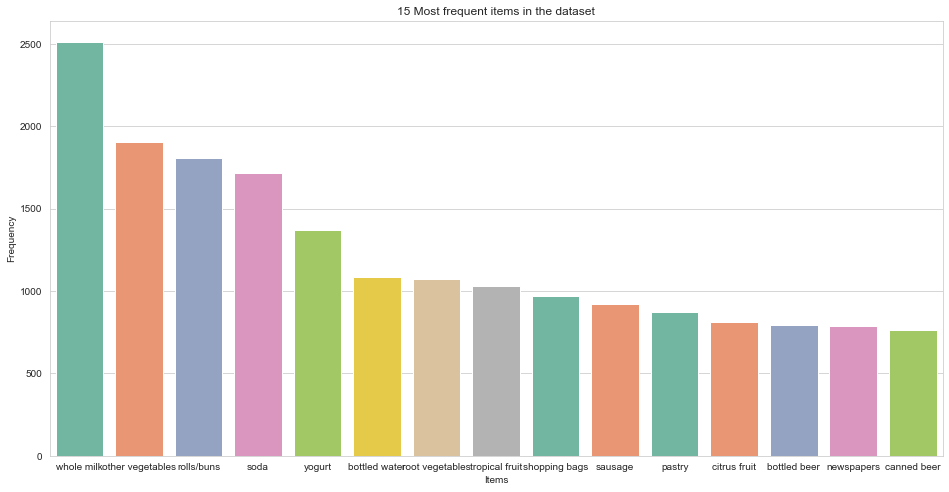

In [9]:
fig = plt.figure(figsize = (16,8))
sns.barplot(x="Items", y="Frequency", data=ic, palette=sns.color_palette("Set2", 10))
plt.xlabel("Items")
plt.ylabel("Frequency")
plt.title(str(n) + " Most frequent items in the dataset")
plt.show()

In [10]:
train_test_split = np.random.rand(len(onehot_items)) < 0.80
train_x = onehot_items[train_test_split]
test_x = onehot_items[~train_test_split]
print()


In [11]:
train_validation_split = np.random.rand(len(train_x)) < 0.80
validation_x = train_x[~train_validation_split]
train_x = train_x[train_validation_split]

In [12]:
def weight_variable(weight_name, weight_shape):
    return tf.get_variable(name = "weight_" + weight_name,shape = weight_shape, 
            initializer = tf.contrib.layers.xavier_initializer()) 

In [13]:
def bias_variable(bias_shape):
    initial = tf.constant(0.1, shape = bias_shape)
    return tf.Variable(initial)

In [14]:
def encoder(x):
    l1 = tf.nn.softsign(tf.add(tf.matmul(x,e_weights_h1),e_biases_h1))
    l2 = tf.nn.softsign(tf.add(tf.matmul(l1,e_weights_h2),e_biases_h2))
    l3 = tf.nn.softsign(tf.add(tf.matmul(l2,e_weights_h3),e_biases_h3))
    l4 = tf.nn.sigmoid(tf.add(tf.matmul(l3,e_weights_h4),e_biases_h4))
    return l4

In [15]:
def decoder(x):
    l1 = tf.nn.softsign(tf.add(tf.matmul(x,d_weights_h1),d_biases_h1))
    l2 = tf.nn.softsign(tf.add(tf.matmul(l1,d_weights_h2),d_biases_h2))
    l3 = tf.nn.softsign(tf.add(tf.matmul(l2,d_weights_h3),d_biases_h3))
    l4 = tf.nn.sigmoid(tf.add(tf.matmul(l3,d_weights_h4),d_biases_h4))
    return l4

#### Terminology

input_dim = 169

n_hidden_1 = 128
n_hidden_2 = 64
n_hidden_3 = 32
n_hidden_4 = 16

training_epochs = 30
batch_size = 50
total_batches = (train_x.shape[0] // batch_size)

learning_rate = 0.00002
keep_prob = 0.6
l2_reg_rate = 0.00001


In [16]:
input_dim = 169

n_hidden_1 = 128
n_hidden_2 = 64
n_hidden_3 = 32
n_hidden_4 = 16

training_epochs = 30
batch_size = 50
total_batches = (train_x.shape[0] // batch_size)

learning_rate = 0.0002 #0.0002
keep_prob = 0.8
l2_reg_rate = 0.000001

In [17]:
tf.reset_default_graph()

In [18]:
is_training = tf.placeholder_with_default(False, shape = ())
X = tf.placeholder(tf.float32, shape=[None,input_dim])
X_drop = tf.contrib.layers.dropout(X, keep_prob, is_training = is_training)
#X_drop = tf.contrib.layers.dropout(X, keep_prob, noise_shape=None, is_training=True, outputs_collections=None, scope=None, seed=None )
print("X_drop", X_drop)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
X_drop Tensor("Dropout/cond/Merge:0", shape=(?, 169), dtype=float32)


##### --------------------- Encoder Variables --------------- ####

In [19]:
e_weights_h1 = weight_variable("el1",[input_dim, n_hidden_1])
e_biases_h1 = bias_variable([n_hidden_1])

e_weights_h2 = weight_variable("el2",[n_hidden_1, n_hidden_2])
e_biases_h2 = bias_variable([n_hidden_2])

e_weights_h3 = weight_variable("el3",[n_hidden_2, n_hidden_3])
e_biases_h3 = bias_variable([n_hidden_3])

e_weights_h4 = weight_variable("el4",[n_hidden_3, n_hidden_4])
e_biases_h4 = bias_variable([n_hidden_4])
e_biases_h4

<tf.Variable 'Variable_3:0' shape=(16,) dtype=float32_ref>



#### --------------------- Decoder Variables --------------- ####

In [20]:
d_weights_h1 = weight_variable("dl1",[n_hidden_4, n_hidden_3])
d_biases_h1 = bias_variable([n_hidden_3])

d_weights_h2 = weight_variable("dl2",[n_hidden_3, n_hidden_2])
d_biases_h2 = bias_variable([n_hidden_2])

d_weights_h3 = weight_variable("dl3",[n_hidden_2, n_hidden_1])
d_biases_h3 = bias_variable([n_hidden_1])

d_weights_h4 = weight_variable("dl4",[n_hidden_1, input_dim])
d_biases_h4 = bias_variable([input_dim])

In [21]:
encoded = encoder(X_drop)
print("HHHH==",encoded)
decoded = decoder(encoded)
print("MMMM==", decoded) 

HHHH== Tensor("Sigmoid:0", shape=(?, 16), dtype=float32)
MMMM== Tensor("Sigmoid_1:0", shape=(?, 169), dtype=float32)


In [22]:
regularizer = tf.contrib.layers.l2_regularizer(l2_reg_rate)
reg_loss = regularizer(e_weights_h1) + regularizer(e_weights_h2) + regularizer(e_weights_h3) + regularizer(e_weights_h4) 
cost_function = -tf.reduce_mean(((X * tf.log(decoded)) + ((1 - X) * tf.log(1 - decoded)))) + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)

In [23]:
with tf.Session() as session:
    Tr_loss=[]
    Val_loss=[]
    tf.global_variables_initializer().run()
    print("Epoch","  ","Tr. Loss"," ","Val. Loss")
    for epoch in range(training_epochs):
        for b in range(total_batches):
            offset = (b * batch_size) % (train_x.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :] 
            _, c = session.run([optimizer, cost_function],feed_dict={X: batch_x, is_training: True})
    
        tr_c = session.run(cost_function,feed_dict={X: train_x, is_training: False})
        val_c = session.run(cost_function,feed_dict={X: validation_x, is_training: False})
        print(epoch+1,"\t",tr_c," ",val_c)
        Tr_loss.append(tr_c)
        Val_loss.append(val_c)
    
    tr_p = session.run(decoded,feed_dict={X: train_x, is_training: False})
    roc_auc = roc_auc_score(train_x,tr_p,average = "samples")
    print("Training ROC AUC: ", round(roc_auc,4))

    val_p = session.run(decoded,feed_dict={X: validation_x, is_training: False})
    roc_auc = roc_auc_score(validation_x,val_p,average = "samples")
    print("Validation ROC AUC: ", round(roc_auc,4))
    
    ts_p = session.run(decoded,feed_dict={X: test_x, is_training: False})
    roc_auc = roc_auc_score(test_x,ts_p,average = "samples")
    print("Test ROC AUC: ", round(roc_auc,4),"\n")
    
    item_preds = session.run(decoded,feed_dict={X: test_x.reshape(-1,169), is_training: False})
    print("ttt==",len(item_preds))
    item_preds[item_preds >= 0.05] = 1
    item_preds[item_preds < 0.05] = 0
    

Epoch    Tr. Loss   Val. Loss
1 	 0.23563087   0.2347874
2 	 0.119787484   0.11836588
3 	 0.10757074   0.10601183
4 	 0.1043764   0.10276632
5 	 0.10315512   0.10152485
6 	 0.10258605   0.10094802
7 	 0.10228628   0.1006457
8 	 0.10211377   0.1004732
9 	 0.10200704   0.10036792
10 	 0.10193642   0.10029945
11 	 0.10188546   0.100250944
12 	 0.101837   0.10020548
13 	 0.09881726   0.09744896
14 	 0.096855186   0.09558894
15 	 0.09608229   0.09486044
16 	 0.09560069   0.09440754
17 	 0.095234215   0.09406203
18 	 0.09491645   0.09376784
19 	 0.094695985   0.09356705
20 	 0.09448703   0.09337272
21 	 0.09430861   0.09320966
22 	 0.09415642   0.09306679
23 	 0.09401847   0.09293478
24 	 0.09387572   0.0928008
25 	 0.09373035   0.09265814
26 	 0.09358133   0.09251281
27 	 0.09342097   0.09234897
28 	 0.09329414   0.09222041
29 	 0.093122296   0.09204189
30 	 0.0929822   0.09189172
Training ROC AUC:  0.8395
Validation ROC AUC:  0.8378
Test ROC AUC:  0.8385 

ttt== 1999


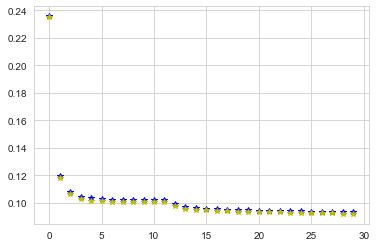

In [24]:
plt.plot(Tr_loss,'b*', Val_loss, 'y*')
plt.show()

In [25]:
"""   
i = 100
#print("Items in basket: ",get_items_from_ohe(test_x[i],unique_items))
print("Recommended item(s): ",get_items_from_ohe(item_preds[i],unique_items))
"""
model = NMF(n_components=100, init='random', random_state=0)
transation_w = model.fit_transform(item_preds)
items_h = model.components_

#get_items_from_ohe(items_h[1],unique_items)

print("Frequent item(s): ",get_items_from_ohe(items_h[0],unique_items))

Frequent item(s):  ['UHT-milk' 'beef' 'berries' 'bottled beer' 'bottled water' 'brown bread'
 'butter' 'canned beer' 'chicken' 'chocolate' 'citrus fruit' 'coffee'
 'cream cheese ' 'curd' 'dessert' 'domestic eggs' 'frankfurter'
 'frozen vegetables' 'fruit/vegetable juice' 'long life bakery product'
 'margarine' 'misc. beverages' 'napkins' 'newspapers' 'other vegetables'
 'pastry' 'pip fruit' 'pork' 'rolls/buns' 'root vegetables' 'salty snack'
 'sausage' 'shopping bags' 'soda' 'sugar' 'tropical fruit' 'waffles'
 'whipped/sour cream' 'white bread' 'whole milk' 'yogurt']


In [26]:
total_transection=9835
for i in range(100):
    xx=np.asarray(np.nonzero(items_h[i]))
    [m,n]=(np.asarray(np.nonzero(items_h[i]))).shape
    support_A_B=len(np.intersect1d(np.nonzero(onehot_items[:,xx[0,n-1]]),np.nonzero(onehot_items[:,xx[0,n-2]])))/total_transection
    #print("{" + str(unique_items[xx[0,n-1]]) + "}" +"=>" "{" + str(unique_items[xx[0,n-2]]) + "}")
    [xxxx,sup_A]=(np.asarray(np.nonzero(onehot_items[:,xx[0,n-1]]))).shape
    [xxxx,sup_B]=(np.asarray(np.nonzero(onehot_items[:,xx[0,n-2]]))).shape
    support_A=sup_A/total_transection
    support_B=sup_B/total_transection
    confidence_A_B=support_A_B / (support_A)
    confidence_B_A=support_A_B / (support_B)
    #lift and conviction
    lift_A_B=confidence_A_B / support_B
    conviction_A_B=(1-support_B)/(1-confidence_A_B)
    print(i+1, "{" + str(unique_items[xx[0,n-1]]) + "}" +"=>" "{" + str(unique_items[xx[0,n-2]]) + "}"+" "+ "support="+ str(round(support_A_B,2)) +" "+ "confidence=" + str(round(confidence_A_B,2))  +" "+ "lift=" + str(round(lift_A_B,2))  +" "+ "conviction=" + str(round(conviction_A_B,2)) )


1 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
2 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
3 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
4 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
5 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
6 {white bread}=>{whipped/sour cream} support=0.01 confidence=0.13 lift=1.82 conviction=1.07
7 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
8 {zwieback}=>{whole milk} support=0.0 confidence=0.25 lift=0.98 conviction=0.99
9 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
10 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
11 {whole milk}=>{soda} support=0.04 confidence=0.16 lift=0.9 conviction=0.98
12 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
13 {yogurt}=>{whole milk} support=0

In [27]:
count=0
for i in range(100):
    if((round(support_A_B,2))>=0.06):
        count+=1
print(count)


100


In [28]:
end = time.time()
print("Time consumed in working: ",end - start)

Time consumed in working:  56.28511714935303
